<a href="https://colab.research.google.com/github/Shamsh-ms/data_science/blob/main/Hyperparameter_Tuning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf


In [2]:
dataset = pd.read_csv("/content/drive/MyDrive/datasets/Dry_Bean_Dataset.csv")
dataset.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [21]:
X = dataset.iloc[:,0:16]
unchanged_y = dataset.iloc[:,-1]
print(X.shape)
print(unchanged_y.shape)
print(type(unchanged_y))

(13611, 16)
(13611,)
<class 'pandas.core.series.Series'>


In [19]:
def change_labels(labels):
  y=[]
  classes = [i for i,label in enumerate(labels.unique())]
  for i in labels:
    if i=='SEKER':
      y.append(classes[0])
    elif i=='BARBUNYA':
      y.append(classes[1])
    elif i=='BOMBAY':
      y.append(classes[2])
    elif i=='CALI':
      y.append(classes[3])
    elif i=='HOROZ':
      y.append(classes[4])
    elif i=='SIRA':
      y.append(classes[5])
    else:
      y.append(classes[6])
  return  np.array([y])


In [40]:
y = change_labels(unchanged_y)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y.reshape(-1,1),test_size=0.3,random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(9527, 16) (4084, 16)
(9527, 1) (4084, 1)


In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
val_x = X_train[:2000,:]
val_y = y_train[:2000]
print(val_x.shape)
print(val_y.shape)

(2000, 16)
(2000, 1)


Installing keras-tuner library which provides hypertuning of parameters

In [30]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 2.2MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78935 sha256=cb0c98bc3e01cccab5aa543b14b6d8d45b7c8d2c227b3227d64cd903b291d860
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=233b56bc195dc69a901d5f906e13038d9713d7e985dcd0219db39edc15f5f459
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [31]:
from kerastuner import RandomSearch

Here we will tune number of layers,number of nuerons(units), and learning rate 

In [36]:
def build_model(hp):
  model = tf.keras.Sequential()
  for i in range(hp.Int('num_layers',2,20)):
    model.add(tf.keras.layers.Dense(units = hp.Int('units_'+str(i),
                                                   min_value=32,
                                                   max_value=512,
                                                   step=32),
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(7,activation='softmax'))
    model.compile(
        optimizer = tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',[1e-2,1e-3,1e-4]),
        ),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    return model

In [38]:
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 3,
)

In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [43]:
tuner.search(X_train,y_train,
             epochs = 5,
             validation_data = (val_x,val_y))

Trial 5 Complete [00h 00m 14s]
val_accuracy: 0.9171666701634725

Best val_accuracy So Far: 0.9356666604677836
Total elapsed time: 00h 01m 05s
INFO:tensorflow:Oracle triggered exit


In [44]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 17
units_0: 32
learning_rate: 0.01
Score: 0.9356666604677836
Trial summary
Hyperparameters:
num_layers: 9
units_0: 416
learning_rate: 0.001
Score: 0.9355000058809916
Trial summary
Hyperparameters:
num_layers: 12
units_0: 32
learning_rate: 0.01
Score: 0.9351666768391927
Trial summary
Hyperparameters:
num_layers: 14
units_0: 384
learning_rate: 0.0001
Score: 0.9171666701634725
Trial summary
Hyperparameters:
num_layers: 3
units_0: 160
learning_rate: 0.0001
Score: 0.8963333368301392


In [61]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]

In [62]:
history = best_model.fit(X_train,y_train,epochs=5,verbose=2,validation_split=0.2)

Epoch 1/5
239/239 - 1s - loss: 0.1990 - accuracy: 0.9257 - val_loss: 0.2101 - val_accuracy: 0.9271
Epoch 2/5
239/239 - 0s - loss: 0.1949 - accuracy: 0.9272 - val_loss: 0.2396 - val_accuracy: 0.9119
Epoch 3/5
239/239 - 0s - loss: 0.1925 - accuracy: 0.9282 - val_loss: 0.2134 - val_accuracy: 0.9218
Epoch 4/5
239/239 - 0s - loss: 0.1935 - accuracy: 0.9272 - val_loss: 0.2213 - val_accuracy: 0.9239
Epoch 5/5
239/239 - 0s - loss: 0.1919 - accuracy: 0.9247 - val_loss: 0.2144 - val_accuracy: 0.9255


In [63]:
score = best_model.evaluate(X_test,y_test)
print("The score metrics is:",score[0],score[1])

128/128 [==============================] - 0s 1ms/step - loss: 0.1959 - accuracy: 0.9305
The score metrics is: 0.1959466189146042 0.9304603338241577


In [64]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

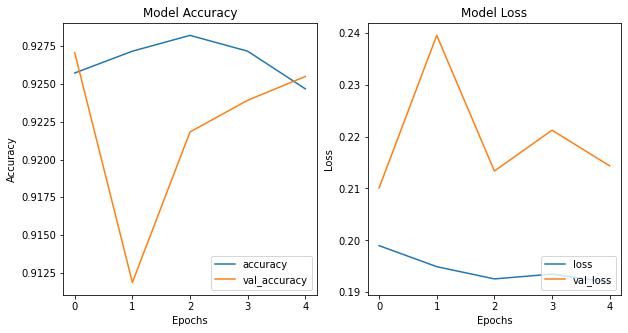

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['accuracy','val_accuracy'],loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['loss','val_loss'],loc='lower right')

In [67]:
pred = best_model.predict(X_test)
pred.shape

(4084, 7)

In [68]:
print(np.argmax(pred[2001]))
print(y_test[2001])

6
[6]


We verified the correctness of predictions by making a random prediction